In [336]:
import numpy as np
import torch
from torch import nn
import torch.utils.data as Data
from torch.nn import functional as F

from pytorch_lightning import Trainer
import pytorch_lightning as pl

from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

In [337]:
class Model(nn.Module):

    def __init__(self, in_channels: int=2,
                latent_dim: int=1,
                hidden_dims = None,
                **kwargs) -> None:

        super(Model, self).__init__()

        self.latent_dim = latent_dim
        self.activation = nn.Tanh()

        in_channels_orig = in_channels
        modules = []
        if hidden_dims is None:
            hidden_dims = [8, 4]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_channels, h_dim),
                    self.activation)
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                    self.activation)
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            #nn.Linear(hidden_dims[-1], hidden_dims[-1]),
                            #nn.LeakyReLU(),
                            nn.Linear(hidden_dims[-1], in_channels_orig))

        self.optimizer = torch.optim.Adam(self.parameters(),
                               lr=1e-2,
                               weight_decay=0)
    
    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        inpu = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, inpu)

        factor = 1 + log_var - mu ** 2 - log_var.exp()
        if len(factor.shape) <= 1: factor = factor.reshape(-1,1)
        kld_loss = torch.mean(-0.5 * torch.sum(factor, dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        # z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [338]:
import time
from datetime import timedelta

def train(epochs, model, dataset, print_training=True):
    # model.train(True)
    mean_loss_epochs = 0
    chars_to_print = 30
    loss_list_epochs = []

    start_time = time.monotonic()
    for t in range(1, epochs+1):
        loss_list = []

        for i, (b_x, b_y) in enumerate(dataset):
            if b_x is None or b_y is None:
                raise Exception()

            model.optimizer.zero_grad()   # clear gradients for next train
            # input x and predict based on x
            prediction = model.forward(b_x)
            train_loss = model.loss_function(*prediction,
                                                # al_img.shape[0]/ self.num_train_imgs,
                                                M_N=0.1)['loss']

            train_loss.backward()                     # backpropagation, compute gradients
            model.optimizer.step()              # apply gradients
            loss_list.append(train_loss.item())
        loss_list_epochs.append(np.mean(loss_list))

        if print_training:
            mean_loss_epochs = np.mean(loss_list_epochs)
            perc = int(t/epochs * chars_to_print)
            dt = timedelta(seconds=time.monotonic()-start_time)
            sys.stdout.write(f"\rEpoch {t}/{epochs}: [" + "="*perc + ">" + "."*(
                chars_to_print-perc) + f"] ({int(t/epochs*100)}%) ETA: {dt} Mean Loss: {mean_loss_epochs:.4f}")
            sys.stdout.flush()

    if print_training:
        dt = timedelta(seconds=time.monotonic()-start_time)
        print(f"\rEpoch {epochs}/{epochs}: [" + "="*chars_to_print +
              f"] (100%) ETA: {dt} Mean Loss: {mean_loss_epochs:.4f}")

    return model, loss_list_epochs

In [339]:
model = Model(latent_dim=1)

X = np.random.uniform(-2, 2, size=(300))
Y = np.abs(X) * (np.sin(X) - np.cos(X))/np.tan(X) + np.random.normal(0, 0.1, size=(len(X)))
ds = np.dstack((X, Y))[0]

ds = np.vstack((ds, np.random.uniform(-2, 2, size=(int(len(ds)), 2))))

ds = torch.FloatTensor(ds)

ds_samples = ds[np.random.randint(0, len(ds), size=(10,))]
torch_dataset = Data.TensorDataset(ds_samples, ds_samples)  # [:,1].unsqueeze(1))

loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=16,
    # num_workers=16,
    shuffle=True)

In [340]:
train(200, model, loader);

Epoch 200/200: [==============================] (100%) ETA: 0:00:00.462176 Mean Loss: 0.69100


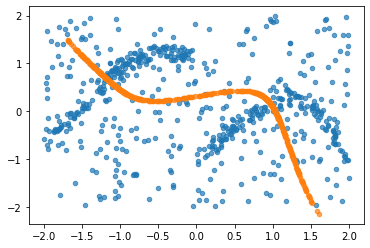

In [341]:
from files.utils.utility_functions import plot
preds = model(ds)[0]

plot(ds)
plot(preds)

In [342]:
from files.classes.neural_models import NeuralNetwork

nen = NeuralNetwork(neurons=[2, 8, 4, 1, 4, 8, 2])
nen.fit(ds_samples, 200, print_training=True, bs=16);

Epoch 200/200: [==============================] (100%) ETA: 0:00:00.001979 Mean Loss: 0.57077


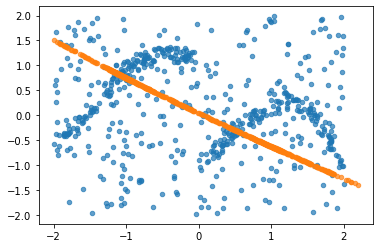

In [343]:
plot(ds)
plot(nen.predict(ds))